In [3]:
import pandas as pd
import numpy as np
from pydantic import BaseModel, Field, ValidationError, validator
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [4]:
class ProfitLossSimulation(BaseModel):

    S0: float = Field(..., gt=0, description="Initial stock price")
    E: float = Field(..., gt=0, alias="strike", description="Strike price")
    mu: float = Field(..., ge=0, le=1, alias="rate", description="rate")
    sigma_actual: float = Field(..., gt=0, le=1, description="actual Volatility")
    sigma_imp: float = Field(..., gt=0, le=1, description="implied Volatility")
    T: int = Field(..., gt=0, le=3650, alias="dates", description="Days to expiration")
    N_paths: int = Field(..., gt=0, alias="npaths", description="Number of simulations")
    n_steps: int = Field(252, gt=0, alias="timesteps", description="Number of timesteps")
   

    class Config:
        allow_population_by_field_name = True

     
        
    @property
    def pseudorandomnumber(self) -> np.ndarray:
        
        np.random.seed(2025)
        w = np.random.standard_normal((self.n_steps, self.N_paths))
        
        return w

    @property
    def pathsimulation(self) -> np.ndarray:
        
        dt = self.T / self.n_steps

        S = np.zeros((self.n_steps, self.N_paths))
        S[0] = self.S0
        w = self.pseudorandomnumber

        for i in range(0, self.n_steps-1):
           
            S[i+1,:] = S[i,:] * (1 + self.mu*dt + self.sigma_actual*np.sqrt(dt)*w[i,:])
           
        return S

    
    def d_one(self, sigma: float) -> np.ndarray:
         
        S = self.pathsimulation
        dt = self.T / self.n_steps
        

        
        d1 = np.zeros((self.n_steps, self.N_paths))

        for i in range(0, self.n_steps-1):
            
            t = dt * i
            tau = self.T - t
            d1[i,:]= (np.log(S[i,:]/self.E) + (self.mu + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))

           

        return d1

    



    @property
    def gammacalculation(self) -> np.ndarray:
        
        S = self.pathsimulation
        dt = self.T / self.n_steps

        gamma_imp = np.zeros((self.n_steps, self.N_paths))
        d1_imp = self.d_one(self.sigma_imp)

        for i in range(0, self.n_steps-1):
            
            t = dt * i
            tau = self.T - t

            gamma_imp[i,:] = norm.pdf(d1_imp[i,:]) / (self.sigma_imp * S[i,:] * np.sqrt(tau))


        return gamma_imp

    @property
    def profit_loss(self) -> np.ndarray:
        
        dt = self.T / self.n_steps
        
        P_L = np.zeros((self.n_steps, self.N_paths))
        S = self.pathsimulation
        
      
        gamma_imp = self.gammacalculation
        
        w = self.pseudorandomnumber
        
        for i in range(0, self.n_steps-1):

            P_L[i+1,:] = P_L[i,:]+ 0.5*(self.sigma_actual**2 - self.sigma_imp**2)*(S[i,:]**2)*gamma_imp[i,:]*dt

        return P_L


In [23]:
simulation02 = ProfitLossSimulation(
                            S0=100, 
                            strike=100, 
                            rate=0.05, 
                            sigma_actual=0.3,
                            sigma_imp=0.2, 
                            dates=1, 
                            npaths=100000, 
                            n_steps=252
                )

In [25]:
PandL = simulation02.profit_loss

Text(0.5, 1.0, 'Simulation of Accumulated P&L - Implied Volatility')

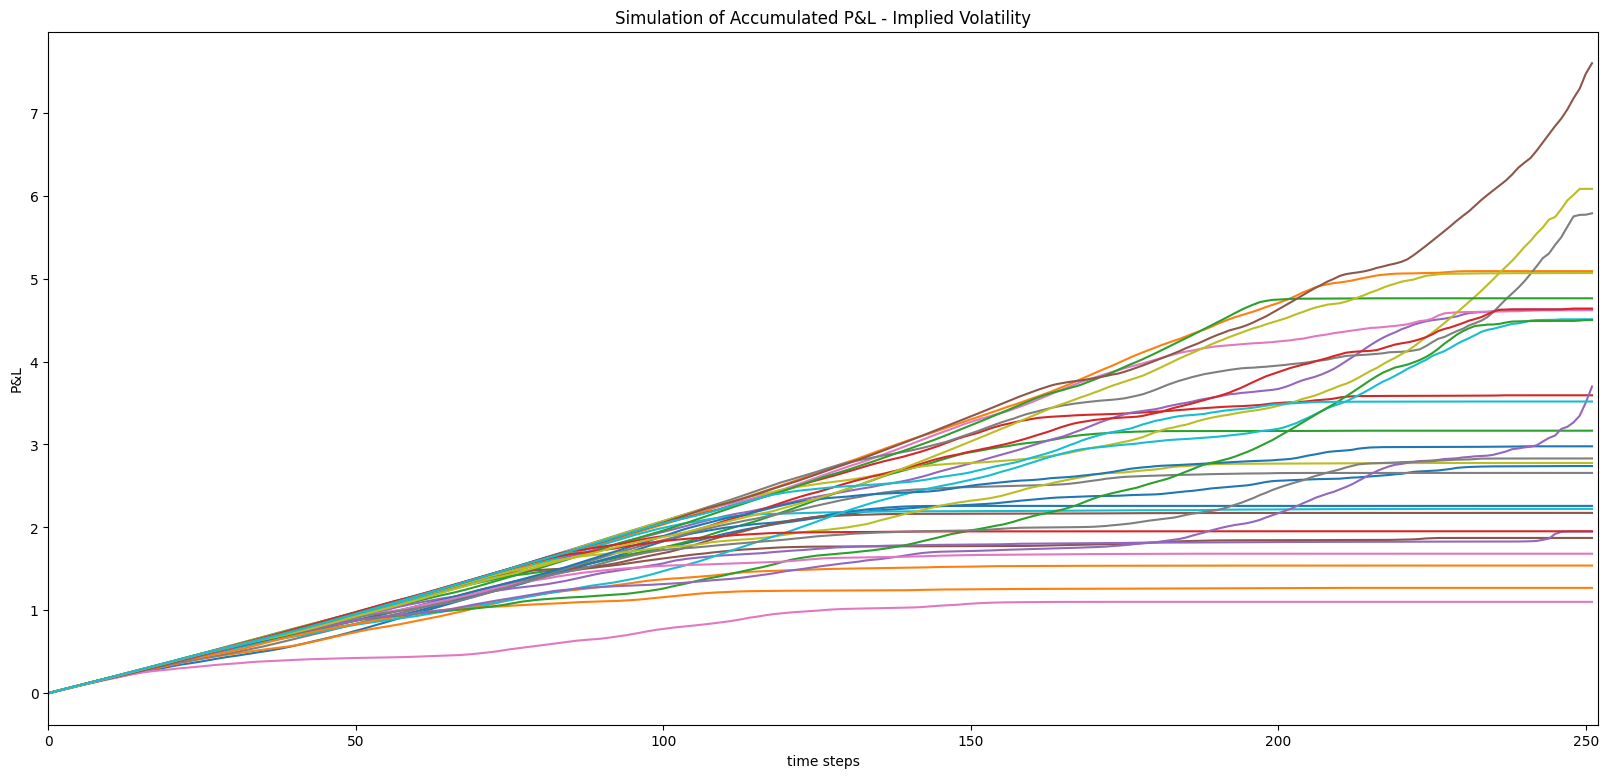

In [26]:
plt.figure(figsize=(20,9))
plt.plot(simulation02.profit_loss[:,:30])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('P&L')
plt.title('Simulation of Accumulated P&L - Implied Volatility')

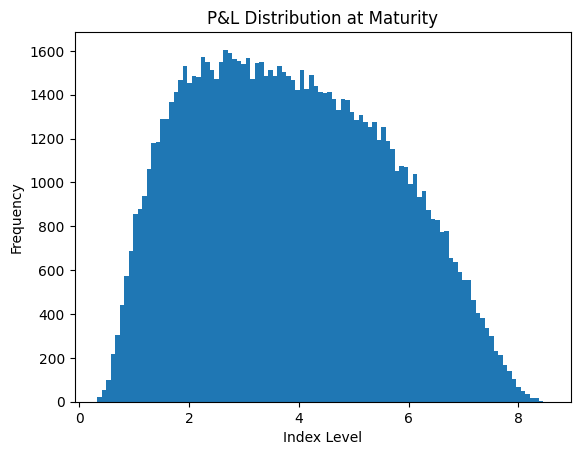

In [29]:
plt.hist(PandL[-1,:].flatten(), bins=100)
plt.title('P&L Distribution at Maturity')
plt.xlabel('Index Level')
plt.ylabel('Frequency')
plt.show()

In [31]:
PandL[-1,:].mean(), PandL[-1,:].std()

(3.8572020270436904, 1.757039616629354)